In [320]:
import pandas as pd
import numpy as np
import json
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns

pd.set_option('display.max_columns', None)

In [321]:
team_metrics_df = pd.read_csv("team_metric_df.csv")
team_metrics_df["over_xg"] = team_metrics_df["goal"]  - team_metrics_df["statsbomb_xg"] 
print(len(team_metrics_df))
team_metrics_df = team_metrics_df.fillna(0)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
def workload_index(df, period):
    return (
        #df[f"Total Distance_{period}"] +#orig
        df[f"Running Distance_{period}"] +#
        3 * df[f"High Speed Running (HSR) Distance_{period}"] +#orig
        #3 * df[f"High Intensity (HI) Distance_{period}"] +
        5 * df[f"Sprinting Distance_{period}"] #orig
    )

# Example: compute workload index for different periods
for period in ["now", "half", "game", "1_week", "2_week", "1_month"]:
    team_metrics_df[f"WI_{period}"] = workload_index(team_metrics_df, period)

# Compute ACWR (Acute:Chronic Workload Ratio)
team_metrics_df["ACWR"] = team_metrics_df["WI_1_week"] / (team_metrics_df["WI_1_month"]/4)
team_metrics_df["ACWR"] = np.where(team_metrics_df["ACWR"].isna(), 0,team_metrics_df["ACWR"])
team_metrics_df["ACWR_bucket"] = pd.cut(
    team_metrics_df["ACWR"],
    bins=[-float('inf'), 0.8, 1.3, 2, float('inf')], 
    labels=["Q1 (lowest)", "Q2", "Q3", "Q4"]
)
team_metrics_df["ACWR_pos"] = np.where(team_metrics_df["ACWR"]>0, 1,0)

In [ ]:
team_metrics_df[["team_name","event_id"]].head(1)

,team_name,event_id
0,Manchester City,24392d1d-314a-4063-a729-7775bc0a2c45


In [ ]:
team_metrics_df = team_metrics_df[(team_metrics_df.WI_1_month!=0)]

In [ ]:
team_metrics_df[["event_id","shot_team_id","ACWR"]].groupby(["event_id","shot_team_id"], as_index=False).mean()

,event_id,shot_team_id,ACWR
0,000192ca-5d86-4797-af38-7fe2d14d9861,24,0.652293
1,0005426e-2055-411b-9e10-36af8f9afb72,214,0.925519
2,0005615c-e54c-458d-b044-715bbfdeb75b,222,0.000000
3,0006ca8e-9b8f-436c-8968-baf6d276523a,172,0.000000
4,0006eec8-f7bd-4dc7-9ca1-1b9fe26bb3b7,172,0.000000
...,...,...,...
44969,fffb3836-1bcc-4cfa-9c6a-f6c54e63a4e6,36,1.171999
44970,fffb428d-7dd3-49cd-874c-9e0bc11fe35c,182,0.314801
44971,fffbc90f-b581-4975-940b-d2989f34e6fe,205,0.000000
44972,fffcc07f-ad47-49eb-a261-1b6c827a6ad7,872,0.000000


In [ ]:
team_metrics_df
group_col = ["event_id","shot_team_id"]#
mean_col = "statsbomb_xg"#'statsbomb_xg'

other_cols = ["ACWR"]


team_agg_df = team_metrics_df[["event_id","shot_team_id","ACWR","statsbomb_xg"]].groupby(["event_id","shot_team_id"], as_index=False).mean()#.drop("event_id",axis=1)
#team_agg_df = event_agg_df.groupby("shot_team_id", as_index=False).mean()

#other_cols = [col for col in team_metrics_df.columns if col not in group_col]

#agg_dict = {mean_col: ['mean']}
#agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

#team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
#team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
#                                for col in team_metrics_df.columns]

team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR"],
    bins=[-float('inf'), 0.8, 1.3, 2, float('inf')], 
    labels=["Q1 (lowest)", "Q2", "Q3", "Q4"]
)
team_agg_df = team_agg_df[team_agg_df["ACWR"]>0]
team_agg_df

,event_id,shot_team_id,ACWR,statsbomb_xg,ACWR_bucket
0,000192ca-5d86-4797-af38-7fe2d14d9861,24,0.652293,0.068080,Q1 (lowest)
1,0005426e-2055-411b-9e10-36af8f9afb72,214,0.925519,0.028856,Q2
8,000854dc-4d6b-45cd-ac57-e8ad16e5fe5d,182,0.748314,0.210336,Q1 (lowest)
9,000c4cff-db1e-4a39-9ba8-d1784b9fcbb5,179,1.129303,0.039272,Q2
10,000c8be4-6547-4480-8f24-d59c8c50fc35,46,0.897993,0.017981,Q2
...,...,...,...,...,...
44965,fff10ce0-ab64-47aa-b66e-4392d27fc3e5,37,0.984963,0.140125,Q2
44967,fff1900c-6ff6-45cb-b30b-a8d2a64329da,207,1.999236,0.122133,Q3
44968,fffaf9f5-f849-41ac-885e-4f78e6fa503d,182,0.517995,0.067922,Q1 (lowest)
44969,fffb3836-1bcc-4cfa-9c6a-f6c54e63a4e6,36,1.171999,0.053872,Q2


<Axes: ylabel='Density'>

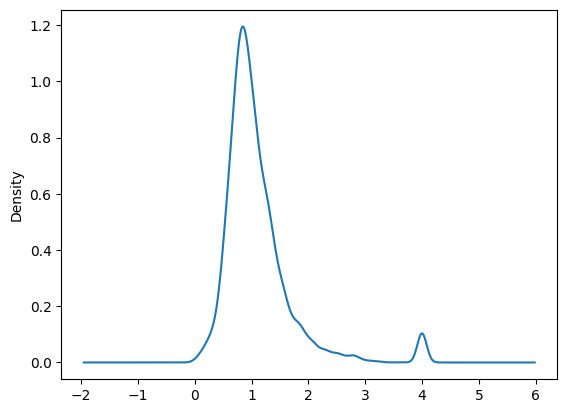

In [ ]:
team_agg_df.ACWR.plot.density()

KeyError: 'Column not found: statsbomb_xg_first'

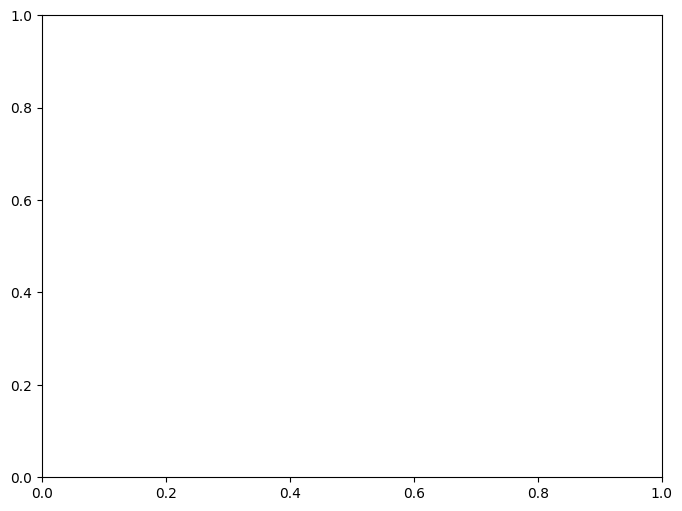

In [ ]:
df = team_agg_df.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="statsbomb_xg_first", by="ACWR_bucket", ax=ax)

# Beautify
ax.set_title("StatsBomb xG by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("StatsBomb xG")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

<Axes: xlabel='statsbomb_xg', ylabel='ACWR'>

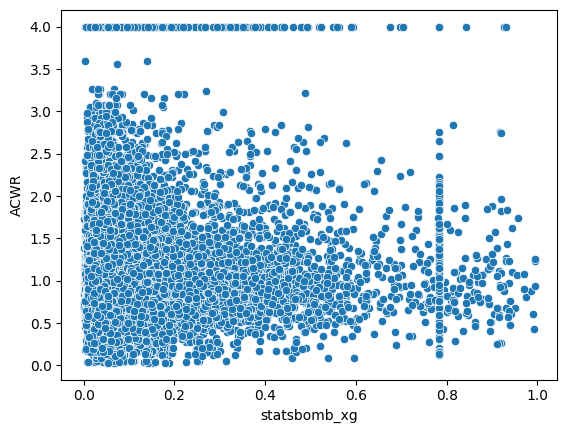

In [ ]:

sns.scatterplot(data=team_agg_df, x="statsbomb_xg", y="ACWR")

see if overall team tiredness affects shots and team creation

group by gameId and event number, with summed metrics and individual metrics and group and indivd acwr? but first xg and over_xg

In [322]:
group_col = ["event_id","shot_team_id"]#
mean_col = 'statsbomb_xg'#"over_xg"#

other_cols = ["ACWR"]

agg_dict = {mean_col: ['first']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in team_agg_df.columns]
team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR_mean"],
    bins=[-float('inf'), 0.8, 1.3, 2, float('inf')], 
    labels=["Q1 (lowest)", "Q2", "Q3", "Q4"]
)

#team_agg_df = team_agg_df[team_agg_df["ACWR_mean"]>0]
df_wide = team_agg_df.pivot(index='event_id', columns='ACWR_bucket', values='statsbomb_xg_first').fillna(0).reset_index()
df_wide.columns.name = None
df_wide = df_wide.drop('event_id',axis=1)

<Axes: ylabel='Density'>

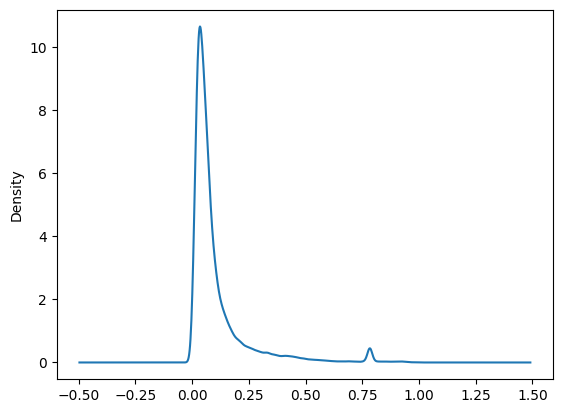

In [323]:
team_metrics_df.statsbomb_xg.plot.density()

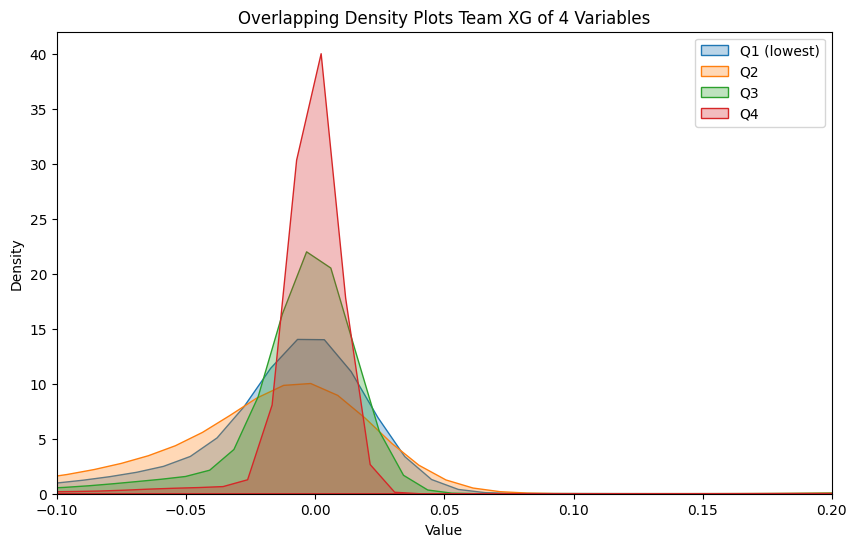

In [347]:
plt.figure(figsize=(10, 6))
for column in df_wide.columns:
    sns.kdeplot(df_wide[column], label=column, fill=True, alpha=0.3)
plt.xlim(-0.1,.2)
plt.title('Overlapping Density Plots Team XG of 4 Variables')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [325]:
df_wide.quantile([0,0.25,0.5,0.75,1]) #use?

,Q1 (lowest),Q2,Q3,Q4
0.00,0.000000,0.000000,0.000000,0.000000
0.25,0.000000,0.000000,0.000000,0.000000
0.50,0.029466,0.000000,0.000000,0.000000
0.75,0.072601,0.000000,0.000000,0.000000
1.00,0.993055,0.994219,0.957286,0.929852


In [326]:
df_wide.median()

Q1 (lowest)    0.029466
Q2             0.000000
Q3             0.000000
Q4             0.000000
dtype: float64

In [327]:
df_wide.mean() #use 

Q1 (lowest)    0.066241
Q2             0.025934
Q3             0.009617
Q4             0.003609
dtype: float64

In [328]:
group_col = ["event_id","shot_team_id"]#
mean_col = "statsbomb_xg"#'statsbomb_xg'

other_cols = ["ACWR"]

agg_dict = {mean_col: ['first']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in team_agg_df.columns]
team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR_mean"],
    bins=[-float('inf'), 0.8, 1.3, 2, float('inf')], 
    labels=["Q1 (lowest)", "Q2", "Q3", "Q4"]
)

#team_agg_df = team_agg_df[team_agg_df["ACWR_mean"]>0]
df_wide = team_agg_df.pivot(index='event_id', columns='ACWR_bucket', values='statsbomb_xg_first').fillna(0).reset_index()
df_wide.columns.name = None
df_wide = df_wide.drop('event_id',axis=1)

In [329]:
df_wide.mean()

Q1 (lowest)    0.066241
Q2             0.025934
Q3             0.009617
Q4             0.003609
dtype: float64

In [330]:
teamlist.team_name

2775      Wolverhampton Wanderers
2785       Brighton & Hove Albion
3100                  Aston Villa
3131                      Everton
3312                      Arsenal
                   ...           
265311              Holstein Kiel
266407                  St. Pauli
340199               Ipswich Town
341380             Leicester City
341633                Southampton
Name: team_name, Length: 63, dtype: object

In [331]:
teamlist = team_metrics_df[["shot_team_id","team_name"]].drop_duplicates()

In [332]:
standard_pl_teams = [
    'Arsenal', 'Aston Villa', 'AFC Bournemouth', 'Brentford', 'Brighton & Hove Albion',
    'Chelsea', 'Crystal Palace', 'Everton', 'Fulham',
    'Liverpool','Manchester City', 'Manchester United',
    'Newcastle United', 'Nottingham Forest',
    'Tottenham Hotspur', 'West Ham United', 'Wolverhampton Wanderers',
    'Ipswich Town', 'Leicester City', 'Southampton'
]

In [333]:
bundesliga_teams = [
    # 2023/24 teams
    'Bayern Munich', 'Bayern München', 'FC Bayern Munich', 'FC Bayern München',
    'Bayer Leverkusen', 'Bayer 04 Leverkusen', 'Leverkusen',
    'VfB Stuttgart', 'Stuttgart',
    'RB Leipzig', 'RasenBallsport Leipzig',
    'Borussia Dortmund', 'Borussia Dortmund', 'BVB', 'Dortmund',
    'Eintracht Frankfurt', 'Frankfurt', 'Eintracht',
    'TSG Hoffenheim', 'Hoffenheim', 'TSG 1899 Hoffenheim',
    'SC Freiburg', 'Freiburg', 'Sport-Club Freiburg',
    'FC Heidenheim', 'Heidenheim', '1. FC Heidenheim',
    'VfL Wolfsburg', 'Wolfsburg',
    'FC Augsburg', 'Augsburg', 'FC Augsburg 1907',
    'Borussia Mönchengladbach', 'Mönchengladbach', 'Gladbach', 'Borussia MGB',
    'Werder Bremen', 'Bremen', 'SV Werder Bremen',
    'Union Berlin', '1. FC Union Berlin',
    '1. FC Köln', 'Köln', 'Cologne', 'FC Köln',
    'Mainz 05', 'Mainz', '1. FSV Mainz 05',
    'VfL Bochum', 'Bochum', 'VfL Bochum 1848',
    'Darmstadt 98', 'Darmstadt', 'SV Darmstadt 98',
    
    # 2024/25 teams (including promoted teams)
    'St. Pauli', 'FC St. Pauli', 'FC Sankt Pauli',
    'Holstein Kiel', 'Kiel', 'KSV Holstein Kiel'
]

In [334]:
group_col = ["match_date","shot_team_id"]#
mean_col = "statsbomb_xg"#'statsbomb_xg'

other_cols = ["ACWR"]

agg_dict = {mean_col: ['first']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in team_agg_df.columns]
team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR_mean"],
    bins=[-float('inf'), 0.8, 1.3, 2, float('inf')], 
    labels=["Q1 (lowest)", "Q2", "Q3", "Q4"]
)
teamname_agg = team_agg_df.merge(teamlist, on="shot_team_id",how="left")
teamname_agg = teamname_agg[teamname_agg.team_name.isin(standard_pl_teams)]
teamname_agg['match_date'] = pd.to_datetime(teamname_agg['match_date'], format='%d/%m/%Y')
teamname_agg = teamname_agg[teamname_agg.match_date>datetime(2024,8,1)]


<Figure size 1200x600 with 0 Axes>

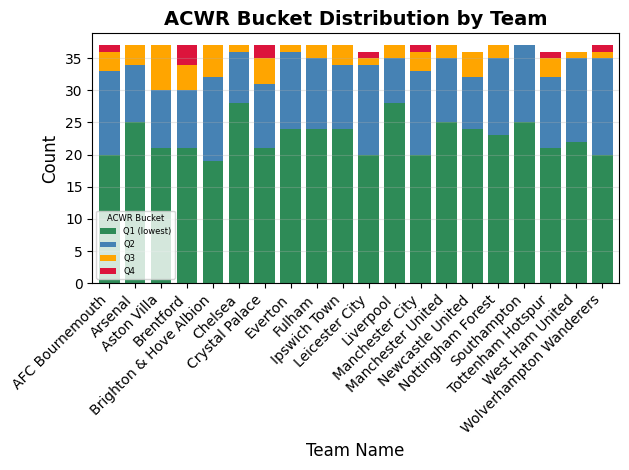

In [335]:
cross_tab = pd.crosstab(teamname_agg['team_name'], teamname_agg['ACWR_bucket'])

# Ensure all 4 ACWR buckets are present (even if some have zero counts)
all_buckets = ['Q1 (lowest)', 'Q2', 'Q3', 'Q4']
for bucket in all_buckets:
    if bucket not in cross_tab.columns:
        cross_tab[bucket] = 0

# Reorder columns to match Q1-Q4 sequence
cross_tab = cross_tab[all_buckets]

# Define colors for each bucket
colors = ['#2E8B57', '#4682B4', '#FFA500', '#DC143C']  # Q1: green, Q2: blue, Q3: orange, Q4: red

# Create the stacked bar chart
plt.figure(figsize=(12, 6))
ax = cross_tab.plot(kind='bar', stacked=True, color=colors, width=0.8)

plt.title('ACWR Bucket Distribution by Team', fontsize=14, fontweight='bold')
plt.xlabel('Team Name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='ACWR Bucket', title_fontsize=6, fontsize=6)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

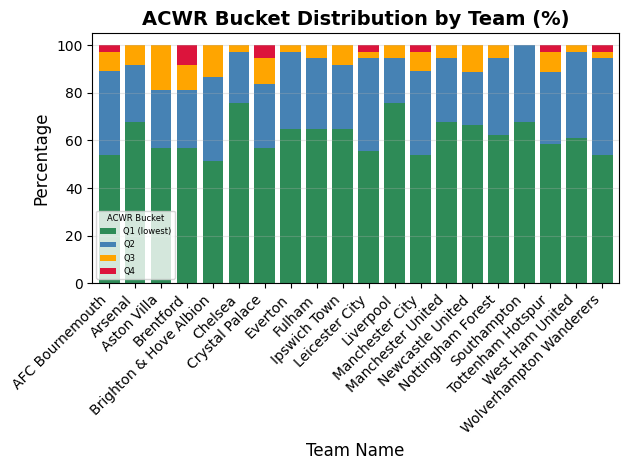

In [336]:
cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# Create percentage stacked bar chart
plt.figure(figsize=(12, 6))
ax = cross_tab_percent.plot(kind='bar', stacked=True, color=colors, width=0.8)

plt.title('ACWR Bucket Distribution by Team (%)', fontsize=14, fontweight='bold')
plt.xlabel('Team Name', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='ACWR Bucket', title_fontsize=6, fontsize=6)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [337]:
group_col = ["event_id","match_date","shot_team_id"]#
mean_col = "statsbomb_xg"#'statsbomb_xg'

other_cols = ["ACWR"]

agg_dict = {mean_col: ['first']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in team_agg_df.columns]
team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR_mean"],
    bins=[-float('inf'), 0.8, 1.3, 2, float('inf')], 
    labels=["Q1 (lowest)", "Q2", "Q3", "Q4"]
)
teamname_agg = team_agg_df.merge(teamlist, on="shot_team_id",how="left")
teamname_agg = teamname_agg[teamname_agg.team_name.isin(standard_pl_teams)]
teamname_agg['match_date'] = pd.to_datetime(teamname_agg['match_date'], format='%d/%m/%Y')
teamname_agg = teamname_agg[teamname_agg.match_date>datetime(2024,8,1)]


<Figure size 1200x600 with 0 Axes>

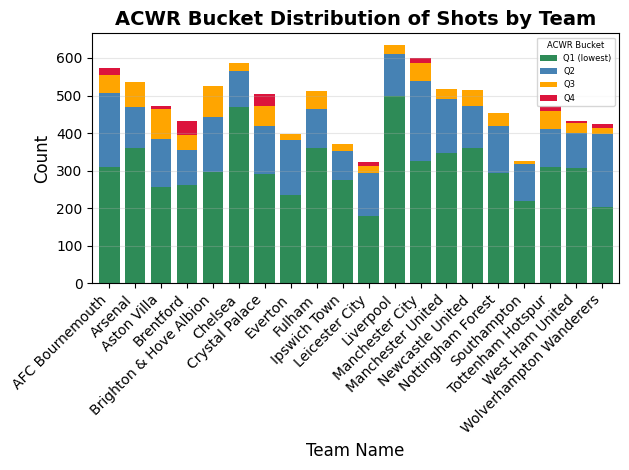

In [338]:
cross_tab = pd.crosstab(teamname_agg['team_name'], teamname_agg['ACWR_bucket'])

# Ensure all 4 ACWR buckets are present (even if some have zero counts)
all_buckets = ['Q1 (lowest)', 'Q2', 'Q3', 'Q4']
for bucket in all_buckets:
    if bucket not in cross_tab.columns:
        cross_tab[bucket] = 0

# Reorder columns to match Q1-Q4 sequence
cross_tab = cross_tab[all_buckets]

# Define colors for each bucket
colors = ['#2E8B57', '#4682B4', '#FFA500', '#DC143C']  # Q1: green, Q2: blue, Q3: orange, Q4: red

# Create the stacked bar chart
plt.figure(figsize=(12, 6))
ax = cross_tab.plot(kind='bar', stacked=True, color=colors, width=0.8)

plt.title('ACWR Bucket Distribution of Shots by Team', fontsize=14, fontweight='bold')
plt.xlabel('Team Name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='ACWR Bucket', title_fontsize=6, fontsize=6)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

plot acwr for leverkusen vs munich for season leverkusen won

In [339]:
team_agg_df[["ACWR_bucket"]].value_counts(normalize=True)

ACWR_bucket
Q1 (lowest)    0.629275
Q2             0.246943
Q3             0.091186
Q4             0.032597
Name: proportion, dtype: float64

In [340]:
df_wide.quantile([0,0.25,0.5,0.75,1])#use

,Q1 (lowest),Q2,Q3,Q4
0.00,0.000000,0.000000,0.000000,0.000000
0.25,0.000000,0.000000,0.000000,0.000000
0.50,0.029466,0.000000,0.000000,0.000000
0.75,0.072601,0.000000,0.000000,0.000000
1.00,0.993055,0.994219,0.957286,0.929852


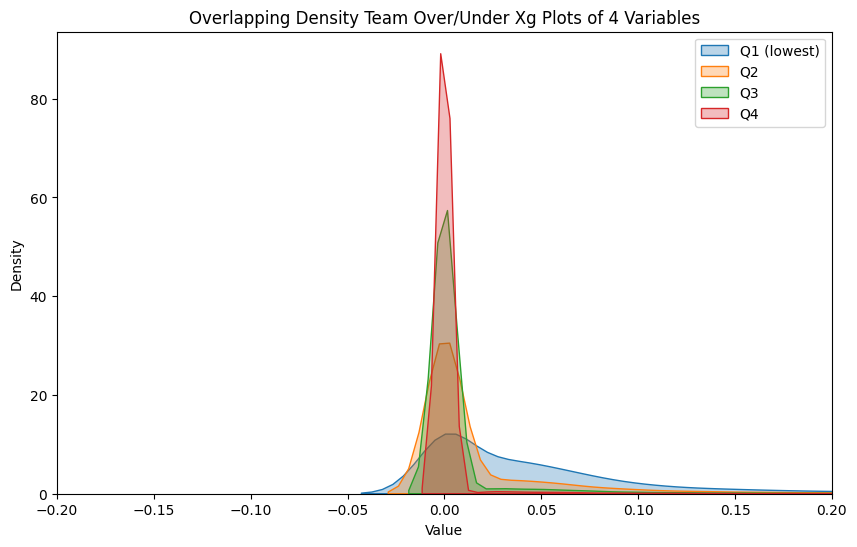

In [341]:
plt.figure(figsize=(10, 6))
for column in df_wide.columns:
    sns.kdeplot(df_wide[column], label=column, fill=True, alpha=0.3)
plt.xlim(-0.2,.2)
plt.title('Overlapping Density Team Over/Under Xg Plots of 4 Variables')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [342]:
df_wide.median()

Q1 (lowest)    0.029466
Q2             0.000000
Q3             0.000000
Q4             0.000000
dtype: float64

In [343]:
df_wide.mean()

Q1 (lowest)    0.066241
Q2             0.025934
Q3             0.009617
Q4             0.003609
dtype: float64

In [344]:
group_col = ["event_id","shot_team_id","match_date"]#
mean_col = "over_xg"#'statsbomb_xg'

other_cols = ["ACWR"]

agg_dict = {mean_col: ['first']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in team_agg_df.columns]
team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR_mean"],
    bins=[-float('inf'), 0.8, 1.3, 2, float('inf')], 
    labels=["Q1 (lowest)", "Q2", "Q3", "Q4"]
)

team_agg_df = team_agg_df[team_agg_df["ACWR_mean"]>0]
df_wide = team_agg_df.pivot(index='event_id', columns='ACWR_bucket', values='over_xg_first').fillna(0).reset_index()
df_wide.columns.name = None
df_wide = df_wide.drop('event_id',axis=1)

In [345]:
team_agg_df

,event_id,shot_team_id,match_date,over_xg_first,ACWR_mean,ACWR_bucket
0,000192ca-5d86-4797-af38-7fe2d14d9861,24,14/09/2024,-0.068080,0.652293,Q1 (lowest)
1,0005426e-2055-411b-9e10-36af8f9afb72,214,22/04/2025,-0.028856,0.925519,Q2
8,000854dc-4d6b-45cd-ac57-e8ad16e5fe5d,182,02/11/2024,-0.210336,0.748314,Q1 (lowest)
9,000c4cff-db1e-4a39-9ba8-d1784b9fcbb5,179,02/03/2024,-0.039272,1.129303,Q2
10,000c8be4-6547-4480-8f24-d59c8c50fc35,46,04/12/2024,-0.017981,0.897993,Q2
...,...,...,...,...,...,...
44965,fff10ce0-ab64-47aa-b66e-4392d27fc3e5,37,28/10/2023,-0.140125,0.984963,Q2
44967,fff1900c-6ff6-45cb-b30b-a8d2a64329da,207,29/11/2024,-0.122133,1.999236,Q3
44968,fffaf9f5-f849-41ac-885e-4f78e6fa503d,182,15/03/2024,0.932078,0.517995,Q1 (lowest)
44969,fffb3836-1bcc-4cfa-9c6a-f6c54e63a4e6,36,04/12/2024,-0.053872,1.171999,Q2


In [346]:
df['match_date'].dt.strftime('%Y-%U')

KeyError: 'match_date'

<Figure size 1600x800 with 0 Axes>

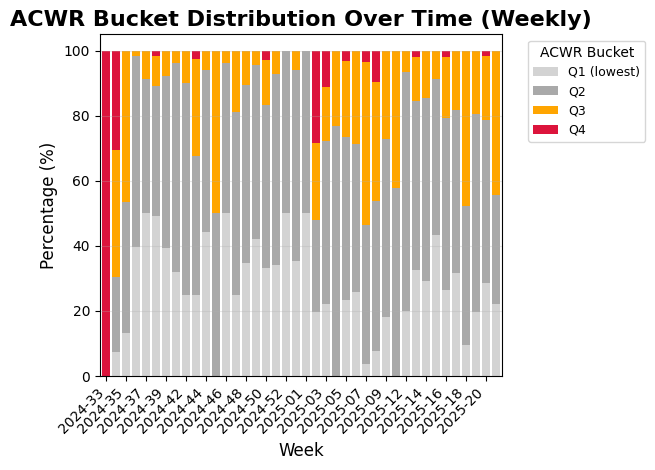

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
df = team_agg_df[["match_date","shot_team_id","ACWR_bucket"]].drop_duplicates()
df['match_date'] = pd.to_datetime(df['match_date'], format='%d/%m/%Y')
df = df[df.match_date>datetime(2024,8,1)]
# Convert match_date to datetime if not already
df['match_date'] = pd.to_datetime(df['match_date'], format='%d/%m/%Y')

# Extract year-week for grouping (you can also use year-month if preferred)
df['year_week'] = df['match_date'].dt.strftime('%Y-%U')  # %U gives week number

# Create cross-tabulation of weeks vs ACWR_bucket counts
cross_tab = pd.crosstab(df['year_week'], df['ACWR_bucket'])

# Ensure all 4 ACWR buckets are present
all_buckets = ['Q1 (lowest)', 'Q2', 'Q3', 'Q4']
for bucket in all_buckets:
    if bucket not in cross_tab.columns:
        cross_tab[bucket] = 0

# Reorder columns to match Q1-Q4 sequence
cross_tab = cross_tab[all_buckets]

# Convert counts to percentages for each week
cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# Define colors for each bucket
colors = ['#2E8B57', '#4682B4', '#FFA500', '#DC143C']
colors = ['#D3D3D3', '#A9A9A9', '#FFA500', '#DC143C']
# Create the percentage stacked bar chart
plt.figure(figsize=(16, 8))
ax = cross_tab_percent.plot(kind='bar', stacked=True, color=colors, width=0.8)

plt.title('ACWR Bucket Distribution Over Time (Weekly)', fontsize=16, fontweight='bold')
plt.xlabel('Week', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
x_labels = [str(period) for period in cross_tab.index]
plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha='right')
ax.set_xticks(ax.get_xticks()[::2])  # Show every second tick
ax.set_xticklabels(x_labels[::2])
plt.legend(title='ACWR Bucket', title_fontsize=10, fontsize=9, 
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

maybe caution that a lot of this is in the early weeks and maybe i'm just describing match sharpness or something

In [ ]:
group_col = ["shot_team_id","match_date"]#
mean_col = "over_xg"#'statsbomb_xg'

other_cols = ["ACWR"]

agg_dict = {mean_col: ['first']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in team_agg_df.columns]
team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR_mean"],
    bins=[-float('inf'), 0.8, 1.3, 2, float('inf')], 
    labels=["Q1 (lowest)", "Q2", "Q3", "Q4"]
)

#team_agg_df = team_agg_df[team_agg_df["ACWR_mean"]>0]
#df_wide = team_agg_df.pivot(index='event_id', columns='ACWR_bucket', values='over_xg_first').fillna(0).reset_index()
#df_wide.columns.name = None
##df_wide = df_wide.drop('event_id',axis=1)
#df_wide

In [ ]:
teamname_agg = team_agg_df.merge(teamlist, on="shot_team_id",how="left")

In [ ]:
teamname_agg['match_date'] = pd.to_datetime(teamname_agg['match_date'], format='%d/%m/%Y')
df = df[df.match_date>datetime(2024,8,1)]
german_title_race = teamname_agg[((teamname_agg.shot_team_id==169)|(teamname_agg.shot_team_id==904))&(teamname_agg.match_date>datetime(2023,8,1))&
  (teamname_agg.match_date<datetime(2024,8,1))           ]


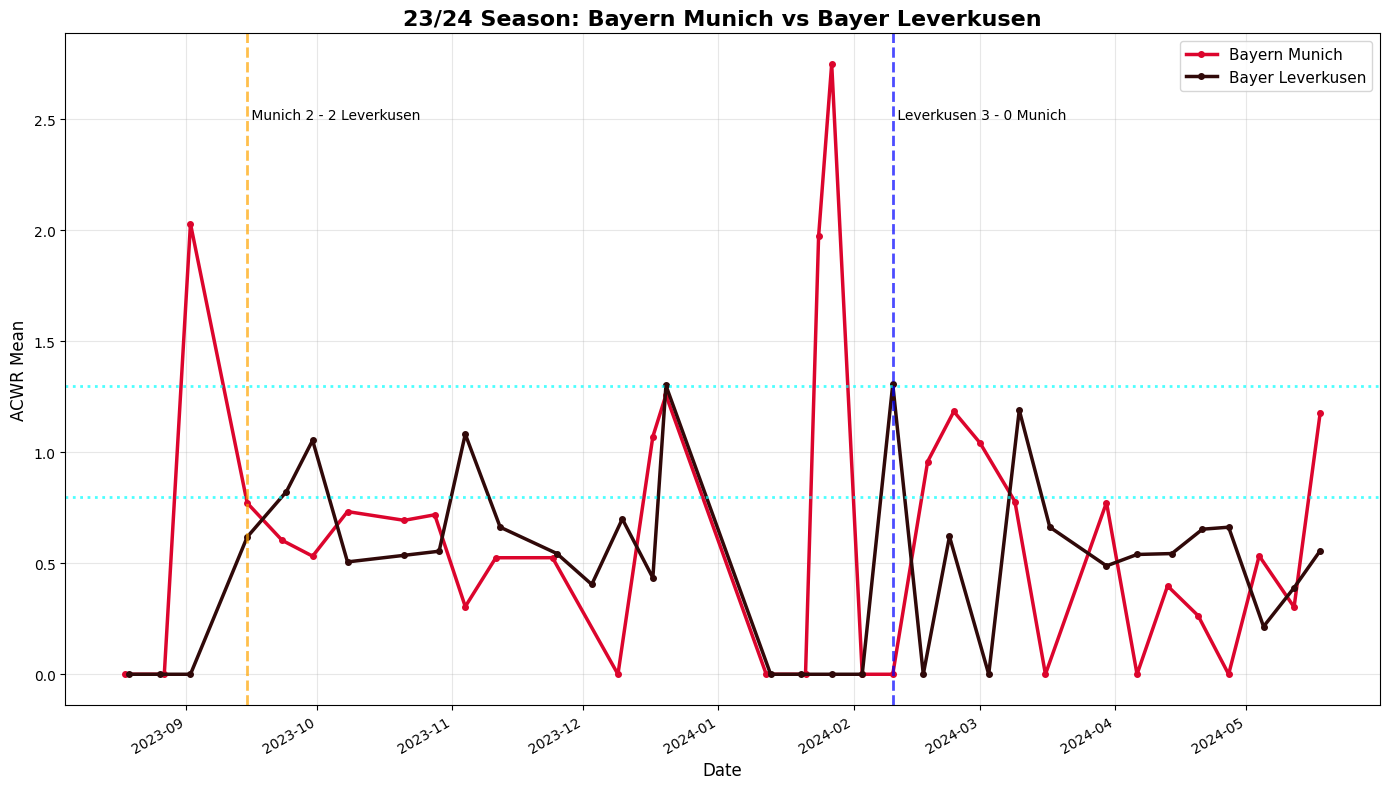

In [ ]:
vertical_line_date1 = pd.to_datetime('2024-02-10')
vertical_line_date2 = pd.to_datetime('2023-09-15')
df_filtered = german_title_race.sort_values('match_date')
teams_to_plot = ['Bayern Munich', 'Bayer Leverkusen']
# Define team colors (traditional club colors)
team_colors = {
    'Bayern Munich': '#DC052D',  # Bayern red
    'Bayer Leverkusen': "#300909"   # Leverkusen red (slightly different shade)
}

# Alternative colors if you prefer more distinction:
# team_colors = {
#     'Bayern Munich': '#DC052D',  # Bayern red
#     'Bayer Leverkusen': '#D7182A'   # Slightly different red
# }

# Or if you want completely different colors for better distinction:
# team_colors = {
#     'Bayern Munich': '#DC052D',     # Bayern red
#     'Bayer Leverkusen': '#FF0000'   # Bright red
# }

# Create the line plot
plt.figure(figsize=(14, 8))

# Plot each team's ACWR_mean over time
for team in teams_to_plot:
    team_data = df_filtered[df_filtered['team_name'] == team]
    plt.plot(team_data['match_date'], team_data['ACWR_mean'], 
             label=team, color=team_colors[team], linewidth=2.5, marker='o', markersize=4)

plt.title('23/24 Season: Bayern Munich vs Bayer Leverkusen', 
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('ACWR Mean', fontsize=12)

plt.axvline(x=vertical_line_date1, color='blue', linestyle='--', linewidth=2, alpha=0.7, 
            label='')
plt.text(vertical_line_date2,2.5,' Munich 2 - 2 Leverkusen')
plt.axvline(x=vertical_line_date2, color='orange', linestyle='--', linewidth=2, alpha=0.7, 
            label='')
plt.text(vertical_line_date1,2.5,' Leverkusen 3 - 0 Munich')
plt.axhline(y=0.8, color='cyan', linestyle=':', linewidth=2, alpha=0.7)
plt.axhline(y=1.3, color='cyan', linestyle=':', linewidth=2, alpha=0.7)
# Format x-axis dates
plt.xticks(rotation=45, ha='right')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()  # Auto-format dates for better readability

plt.tight_layout()
plt.show()